# Pylops - local Transorms (e.g. sliding Radon)

In this notebook we will consider the case a linear or Radon transform can only be used to explain a certain 2d signal (e.g. seismic data) locally. We will thus develop a sliding window operator that takes N representations of portion of the signal in the Radon domain, converts them to the time-space domain and combines them via a sliding window approach (with tapering and overlap)

Mathematically speaking we will have an operator

$$\mathbf{SW} = \mathbf{Combine} * \mathbf{Op} * \mathbf{Slice}$$

where $\mathbf{Slice}$ extracts patches of the model, $\mathbf{Op}$ applies the same operator (e.g., forward Radon) to each patch, $\mathbf{Combine}$ recombines the outputs of $\mathbf{Op}$ (possibly with sliding windows and overlaps).

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import LinearOperator, cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA

We start by creating a data with 3 hyperbolic events

(-0.5, 139.5, 199.5, -0.5)

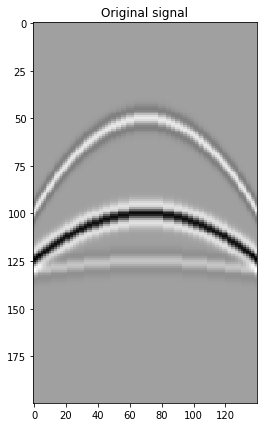

In [2]:
###### Input parameters
par = {'ox':-140, 'dx':2,    'nx':140,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-6]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

plt.figure(figsize=(4,7))
plt.imshow(data.T, cmap='gray')
plt.title('Original signal')
plt.axis('tight')

We then subdivide it into several patches (along the space axis) and compute the radon transform for each patch. 

In [3]:
def slidingwindows_steps(ntrace, ntap, nover):
    """Create sliding window initial and end points

    :param int  ntrace:   lenght of trace to which sliding window processing is applied
    :param int  ntap:     number of space samples for taper
    :param int  nover:    lenght of overlapping part of taper

    :return:              start and end points
    :rtype:               np.array, np.array
    """
    if ntap>ntrace:
        raise ValueError('Slidingprocessing.slidingwindows_steps (ntrace=%d, ntap=%d): Provide ntap smaller than ntrace...' % (ntap, ntrace))

    step   = ntap - nover
    starts = np.arange(0, ntrace - ntap + 1, step, dtype=np.int)
    ends   = starts + ntap

    return starts, ends

In [4]:
nwin = 20
nover = 0
dims = data.shape

# Windows data
win_ins, win_ends = slidingwindows_steps(dims[0], nwin, nover)
# Windows radon
win_ins, win_ends = slidingwindows_steps(dims[0], nwin, nover)

# Transform to apply
#Op = BlockDiag([Identity(nwin*dims[1]) for i in range(len(win_ins))])
px = np.linspace(-1e-2, 1e-2, 20)
Op = BlockDiag([Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                        kind='linear', onthefly=False) for _ in range(len(win_ins))])

slicing = VStack([Restriction(np.prod(dims), range(win_in, win_end), dims=dims) 
                  for win_in, win_end in zip(win_ins, win_ends)])
combining = HStack([Restriction(np.prod(dims), range(win_in, win_end), dims=dims).H 
                  for win_in, win_end in zip(win_ins, win_ends)])
#masks = np.zeros_like(win_ins)
#masks[0] = 1
#summing = HStack([mask*Restriction(np.prod(dims), range(win_in, win_end), dims=dims).H 
#                  for win_in, win_end, mask in zip(win_ins, win_ends, masks)])

opsliding = combining*Op.H*slicing
opslidingadj = combining*Op*slicing

radon = opsliding*data.flatten()
reconstructed_data = opslidingadj*radon.flatten()

radon = radon.reshape(dims)
reconstructed_data = reconstructed_data.reshape(dims)

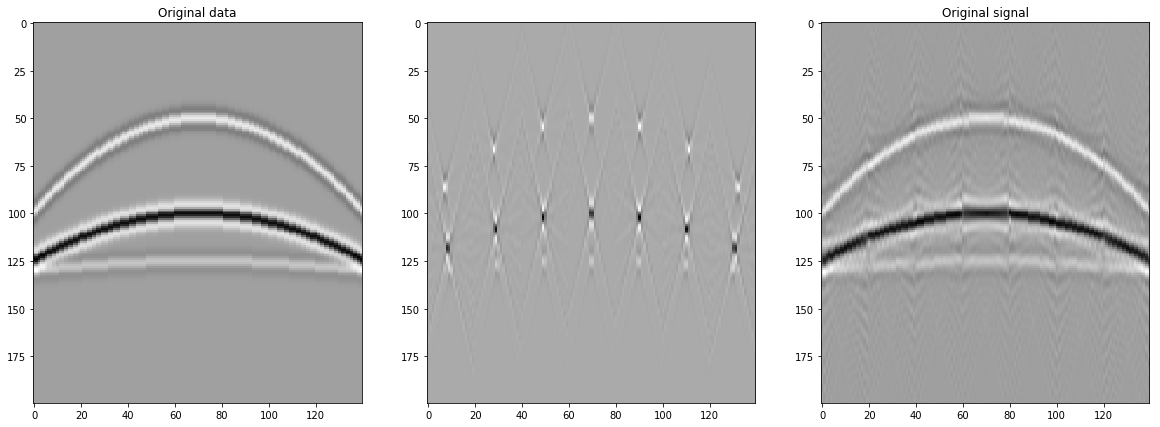

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs[0].imshow(data.T, cmap='gray')
axs[0].set_title('Original data')
axs[0].axis('tight')
axs[1].imshow(radon.T, cmap='gray')
axs[2].set_title('Radons for each data patch')
axs[1].axis('tight')
axs[2].imshow(reconstructed_data.T, cmap='gray')
axs[2].set_title('Original signal')
axs[2].axis('tight');